In [ ]:
import h5py
import core.init as init
import core.utility as utility
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as jv
import cycler, fssa
from scipy.ndimage import gaussian_filter1d as gf
from jax.numpy.linalg import norm as frn

import warnings
warnings.filterwarnings('ignore')

# Part to change plotting system
# Slows things down a little but makes nicer plots
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import inset_axes
mpl.rcParams['figure.figsize'] = (16,6)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})
plt.rc('text', usetex=True)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

# Parameters
L = 24                          # Linear system size
dim = 1                         # Spatial dimension
n = L**dim                      # Total number of sites
species = 'spinless fermion'    # Type of particle
dsymm = 'charge'                # Type of disorder (spinful fermions only)
Ulist = [0.1]
# List of interaction strengths
J = 1.0                         # Nearest-neighbour hopping amplitude
cutoff = J*10**(-3)             # Cutoff for the off-diagonal elements to be considered zero
dis = [0.5+0.5*i for i in range(8,10)]
# List of disorder strengths
lmax = 500                      # Flow time max
qmax = 2500                     # Max number of flow time steps
reps = 1                        # Number of disorder realisations
norm = False                    # Normal-ordering, can be true or false
intr = True                     # Turn on/off interactions
dyn = False
imbalance = True                # Sets whether to compute global imbalance or single-site dynamics
LIOM = 'bck'                    # Compute LIOMs with forward ('fwd') or backward ('bck') flow
                                # Forward uses less memory by a factor of qmax, and transforms a local operator
                                # in the initial basis into the diagonal basis; backward does the reverse
dis_type = 'random'             # Options: 'random', 'QPgolden', 'QPsilver', 'QPbronze', 'QPrandom', 'linear', 'curved', 'prime'
                                # Also contains 'test' and 'QPtest', potentials that do not change from run to run
xlist = [0.1*i for i in range(1,10)]
# For 'dis_type = curved', controls the gradient of the curvature
if intr == False:               # Zero the interactions if set to False (for ED comparison and filename)
    delta = 0
if dis_type != 'curved':
    xlist = [0.0]

# Make directory to store data
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species,4)

: 

# Main Text

### Figure 3: Complexity

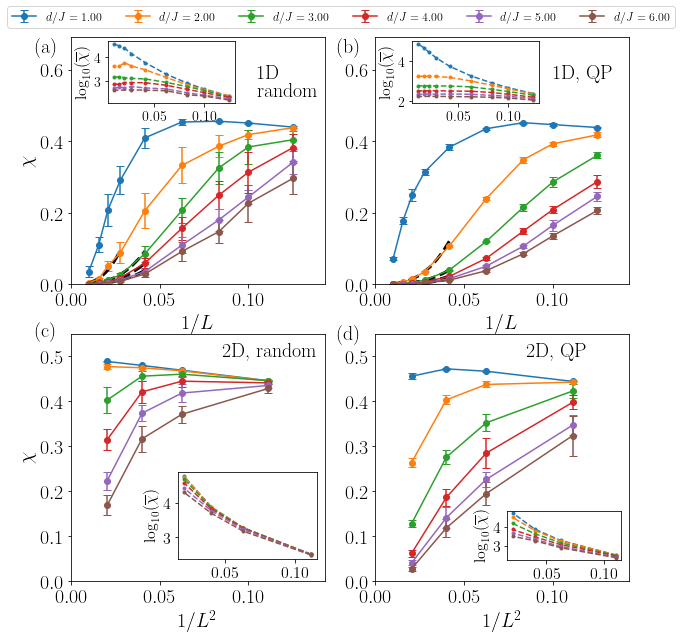

In [28]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
mpl.rcParams['figure.figsize'] = (10,10)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
ax3,ax4 = axes[1]
axlist = [ax1,ax2,ax3,ax4]
ax_count = 0

n = 16
order = 4

x = 0.0
delta = 0.1
tlist = np.logspace(-2,5,151,base=10,endpoint=True)
reps = 10

nlist = [8,10,12,16,24,36,48,64,100]

for dis_type in ['random','QPgolden']:
    ax = axlist[ax_count]
    ax_ins = inset_axes(ax, width="50%",  height="25%",bbox_to_anchor=(-0.315,0.025,1,1), bbox_transform=ax.transAxes)
    ax_ins.tick_params(axis='x',which='both',labelsize=14)
    ax_ins.tick_params(axis='y',which='both',labelsize=14)
    ax_ins.set_ylabel(r'$\log_{10}(\overline{\chi})$', fontsize=16)
    
    for d in [1.0,2.0,3.0,4.0,5.0,6.0]:
        itc_list = []
        itc_varlist = []
        
        itc_list2 = []
        itc_varlist2 = []
        for n in nlist:
            nvar = utility.namevar2(dis_type,1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
            felist = []
            felist2 = []
            for p in range(1,reps+1):
                try:
                    with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                        felist += [np.array(hf.get('complexity'))[0]]
#                         felist += [np.array(hf.get('ltc'))]
                except:
                    None
            itc_list += [np.mean(felist,axis=0)]
            itc_varlist += [np.sqrt(np.var(felist,axis=0))]
            
            itc_list2 += [(n+n**3)*np.mean(felist,axis=0)]
            itc_varlist2 += [np.sqrt(np.var((n+n**3)*felist,axis=0))]
        itc_list = np.array(itc_list)
        mask = np.isfinite(itc_list)
        ax.errorbar([1/i for i in np.array(nlist)[mask]],np.array(itc_list)[mask],np.array(itc_varlist)[mask],fmt='o-',capsize=4,label=r'$d/J = %.2f$' %d)
        ax_ins.plot([1/(i) for i in np.array(nlist)[mask]],np.log10(np.array(itc_list2)[mask]),'o--',markersize=3)
        
        if d > 1.0:
            try:
                length = 5
                fit = np.polynomial.polynomial.Polynomial.fit([1/(m) for m in nlist[length::]],itc_list[length::],deg = [3],w=[1/s for s in np.sqrt(itc_varlist[length::])],domain=[]).coef
                if dis_type == 'random' and d == 2.0:
                    steps = np.linspace(1/nlist[-1],1/nlist[-4],10)
                else:
                    steps = np.linspace(1/nlist[-1],1/nlist[-5],10)
                ax.plot(steps,[fit[3]*(i**3) for i in steps],'k--',lw=3)
            except:
                None
            

    ax_count += 1
  
nlist = [9,16,25,49]
for dis_type in ['random','QPgolden']:
    ax = axlist[ax_count]
    if dis_type == 'random':
        ax_ins = inset_axes(ax, width="55%",  height="35%",bbox_to_anchor=(0.01,-0.52,1,1), bbox_transform=ax.transAxes)
    else:
        ax_ins = inset_axes(ax, width="45%",  height="20%",bbox_to_anchor=(0.01,-0.675,1,1), bbox_transform=ax.transAxes)
    ax_ins.tick_params(axis='x',which='both',labelsize=16)
    ax_ins.tick_params(axis='y',which='both',labelsize=16)
#     ax_ins.set_xlabel(r'$1/L^2$', fontsize=12)
    ax_ins.set_ylabel(r'$\log_{10}(\overline{\chi})$', fontsize=16)
    
    for d in [1.0,2.0,3.0,4.0,5.0,6.0]:
        itc_list = []
        itc_list2 = []
        itc_varlist = []
        itc_varlist2 = []
        for n in nlist:
            nvar = utility.namevar2(dis_type,2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
            felist = []
            felist2 = []
            for p in range(1,reps+1):
                try:
                    with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                        felist += [np.array(hf.get('complexity'))[0]]
                except:
                    None
            itc_list += [np.mean(felist,axis=0)]
            itc_list2 += [(n+n**3)*np.mean(felist,axis=0)]
            itc_varlist += [np.sqrt(np.var(felist,axis=0))]
            itc_varlist2 += [np.sqrt(np.var((n+n**3)*felist,axis=0))]
        itc_list = np.array(itc_list)
        ax.errorbar([1/(i) for i in nlist],itc_list,itc_varlist,fmt='o-',capsize=4,label=r'$L = %s$')
        ax_ins.plot([1/(i) for i in nlist],np.log10(itc_list2),'o--',markersize=3)

        
    ax_count += 1
        
ax1.legend(ncol=6,fontsize=12,loc='upper left',bbox_to_anchor=(-0.275,1.15))

ax1.set(xlim=(0,1/7),ylim=(0,0.69))
ax2.set(xlim=(0,1/7),ylim=(0,0.69))
ax3.set(xlim=(0,1/7),ylim=(0,0.55))
ax4.set(xlim=(0,1/7),ylim=(0,0.55))

ax1.text(0.105,0.575,r'1D')
ax1.text(0.105,0.525,r'random')
ax2.text(0.10,0.575,r'1D, QP')
# ax2.text(0.1,0.57755,r'QP')
ax3.text(0.085,0.5,r'2D, random')
ax4.text(0.085,0.5,r'2D, QP')

ax1.set(ylabel=r'$\chi$',xlabel=r'$1/L$')
ax2.set(xlabel=r'$1/L$')
ax3.set(ylabel=r'$\chi$',xlabel=r'$1/L^2$')
ax4.set(xlabel=r'$1/L^2$')

ax1.text(-0.02,0.65,r'(a)',zorder=20)
ax1.text(0.15,0.65,r'(b)',zorder=20)
ax1.text(-0.02,-0.145,r'(c)',zorder=20)
ax1.text(0.15,-0.154,r'(d)',zorder=20)

plt.savefig('fig3.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

### Figure 4: Correlation Function Dynamics

1.0 255 128
1.0 255 107
3.0 255 127
3.0 255 127
5.0 255 64
5.0 255 64
1.0 256 62
1.0 256 63
3.0 256 59
3.0 256 60
5.0 256 55
5.0 256 63


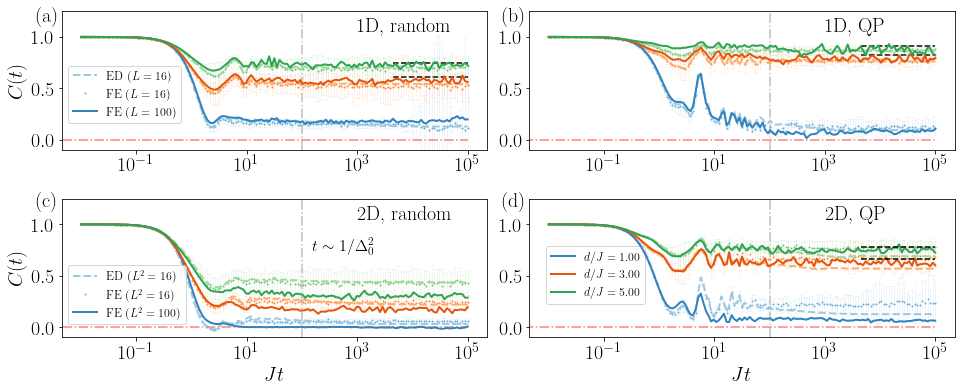

In [27]:
mpl.rcParams['figure.figsize'] = (16,6)
plt.rcParams.update({'font.size': 20})
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
ax3,ax4 = axes[1]
axlist = [ax1,ax2,ax3,ax4]

from scipy.ndimage import gaussian_filter1d as gf

n = 16
order = 4
x = 0.0
delta = 0.1
tlist = np.logspace(-2,5,151,base=10,endpoint=True)
reps = 256
dlist = [1.0,3.0,5.0]

for d in dlist:
    for dtype in ['random','QPgolden']:
        if dtype == 'random':
            ax = ax1
        else:
            ax = ax2
            
        edlist = []
        felist = []
        felist2 = []
        felist3 = []
        for p in range(reps):
            try:
                nvar = utility.namevar2(dtype,1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    itc = np.array(hf.get('itc'))
                    felist += [itc]
                    edlist += [np.array(hf.get('ed_itc'))]
            except:
                None
                
            try:
                nvar = utility.namevar2(dtype,1,dsymm,'CDW',dyn,norm,100,LIOM,species,order)
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    itc = np.array(hf.get('itc'))
                    felist2 += [itc]
                    felist3 += [np.array(hf.get('ltc'))]
            except:
                None
                
        corr = np.mean(felist,axis=0)
        var = np.var(felist,axis=0)
        ed = np.mean(edlist,axis=0)
        ltc = np.mean(felist3,axis=0)
        ax.plot(tlist,np.mean(felist2,axis=0),'-',alpha=1.,linewidth=2,zorder=30,label=r'$d/J = %.2f$' %d)
        if d > 2:
            ax.plot(tlist[-30::],ltc*np.ones(len(tlist[-30::])),'k--')
        if dtype == 'random':
            markers,caps,bars =  ax.errorbar(tlist,corr,var,fmt='s',markersize=1,capsize=2,linewidth=2,elinewidth=1)
        if dtype == 'QPgolden':
            markers,caps,bars =  ax.errorbar(tlist,corr,var,fmt='s',markersize=1,capsize=2,linewidth=2,elinewidth=1)
        edp = ax.plot(tlist,ed,'--',linewidth=2,zorder=20,alpha=1.)
        ax.plot(tlist,np.mean(felist2,axis=0),'-',alpha=0.,linewidth=2,zorder=30)
        [bar.set_alpha(0.1) for bar in bars]
        [cap.set_alpha(0.1) for cap in caps]
 
for d in dlist:
    for dtype in ['random','QPgolden']:
        if dtype == 'random':
            ax = ax3
        else:
            ax = ax4
            
        nvar = utility.namevar2(dtype,2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
        edlist = []
        felist = []
        felist2 = []
        felist3 = []
        for p in range(1,reps+1):
            try:
                nvar = utility.namevar2(dtype,2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    itc = np.array(hf.get('itc'))
                    felist += [itc]
                    edlist += [np.array(hf.get('ed_itc'))]
            except:
                None
                
            try:
                if p < 65:
                    nvar = utility.namevar2(dtype,2,dsymm,'CDW',dyn,norm,100,LIOM,species,order)
                    with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                        itc = np.array(hf.get('itc'))
                        if np.max(np.abs(itc)) < 1.1:
                            felist2 += [itc]
                        felist3 += [np.array(hf.get('ltc'))]
            except:
                None
        corr = np.mean(felist,axis=0)
        var = np.var(felist,axis=0)
        ed = np.mean(edlist,axis=0)
        ltc = np.mean(felist3,axis=0)
        ax.plot(tlist,np.mean(felist2,axis=0),'-',alpha=1.,linewidth=2,zorder=30,label=r'$d/J = %.2f$' %d)
        if d > 2 and dtype == 'QPgolden':
            ax.plot(tlist[-30::],ltc*np.ones(len(tlist[-30::])),'k--',zorder=50)
        if dtype == 'random':
            markers,caps,bars =  ax.errorbar(tlist,corr,var,fmt='o',markersize=1,capsize=2,linewidth=2,elinewidth=1)
        if dtype == 'QPgolden':
            markers,caps,bars =  ax.errorbar(tlist,corr,var,fmt='o',markersize=1,capsize=2,linewidth=2,elinewidth=1)
#         ax.plot(tlist,np.mean(felist2,axis=0),'k--',alpha=1.,linewidth=2,zorder=10)
        [bar.set_alpha(0.1) for bar in bars]
        [cap.set_alpha(0.1) for cap in caps]
        ax.plot(tlist,ed,'--',linewidth=2,zorder=20,alpha=1.)
        ax.plot(tlist,np.mean(felist2,axis=0),'-',alpha=0.,linewidth=2,zorder=30)

lines = plt.gca().get_lines()
include = [0,2,4,6]
legend1 = plt.legend([lines[i] for i in [4,1,0]],[r'ED ($L=16$)',r'FE ($L=16$)',r'FE ($L=100$)'], loc='lower left',bbox_to_anchor=(-1.1,1.5),fontsize=12)
plt.gca().add_artist(legend1)

legend1 = plt.legend([lines[i] for i in [4,1,0]],[r'ED ($L^2 = 16$)',r'FE ($L^2 = 16$)',r'FE ($L^2 = 100$)'], loc='lower left',bbox_to_anchor=(-1.1,0.05),fontsize=12)
plt.gca().add_artist(legend1)

plt.legend(fontsize=12, loc='lower left',bbox_to_anchor=(0.025, 0.2))

for ax in axlist:
    ax.set(xscale='log',ylim=(-0.1,1.25))
    ax.hlines([0.],0,1e5,colors=['r'],linestyles='-.',alpha=0.5)
    ax.vlines([100.],-0.1,1.25,colors=['gray'],linestyles='-.',alpha=0.5)
ax3.text(150,0.75,r'$t \sim 1/\Delta_0^2$',fontsize=16)
for ax in [ax3,ax4]:
    ax.set(xlabel=r'$Jt$')
for ax in [ax1,ax3]:
    ax.set(ylabel=r'$C(t)$')

ax1.text(1e3,1.05,r'1D, random')
ax2.text(1e3,1.05,r'1D, QP')
ax3.text(1e3,1.05,r'2D, random')
ax4.text(1e3,1.05,r'2D, QP')

ax1.text(0.0015,1.15,r'(a)')
ax1.text(4.25e5,1.15,r'(b)')
ax1.text(0.0015,-0.65,r'(c)')
ax1.text(4.25e5,-0.65,r'(d)')

plt.subplots_adjust(hspace=0.35,wspace=0.1)
plt.savefig('fig4.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

### Figure 5: Finite-Size Scaling

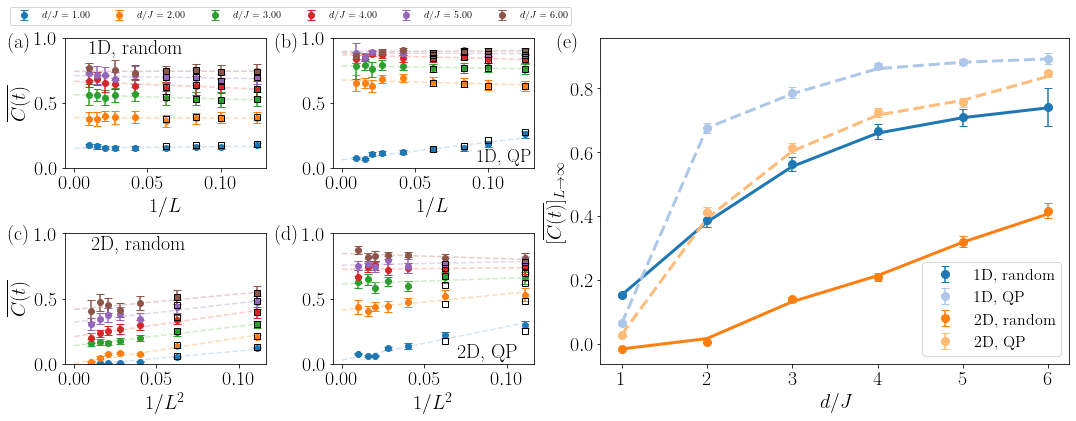

In [3]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
mpl.rcParams['figure.figsize'] = (18,6)

fig, axes = plt.subplot_mosaic("ABDD;CEDD")
axlist = ["A","B","C","E","D"]
ax_count = 0

n = 16
order = 4

x = 0.0
delta = 0.1
tlist = np.logspace(-2,5,151,base=10,endpoint=True)
reps = 1024

nlist = [8,10,12,16,24,36,48,64,100]
dlist = [1.0,2.0,3.0,4.0,5.0,6.0]

ltc = np.zeros(6)
ltc_err = np.zeros(6)
for dis_type in ['random','QPgolden']:
    ax = axes[axlist[ax_count]]
    dc = 0
    for d in [1.0,2.0,3.0,4.0,5.0,6.0]:
        itc_list = []
        itc_list2 = []
        ed_list = []
        itc_varlist = []
        for n in nlist:
            nvar = utility.namevar2(dis_type,1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
            felist = []
            felist2 = []
            felist3 = []
            for p in range(1,reps+1):
                try:
                    with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                        felist += [np.mean(np.array(hf.get('itc'))[-72:-43],axis=0)]
                        if n < 20:
                            felist2 += [np.mean(np.array(hf.get('ed_itc'))[-72:-43],axis=0)]
                except:
                    None
            itc_list += [np.mean(felist,axis=0)]
            if n < 20:
                ed_list += [np.mean(felist2,axis=0)]
            itc_varlist += [np.var(felist,axis=0)]
    
        ax.errorbar([1/i for i in nlist],itc_list,itc_varlist,fmt='o',capsize=4,label=r'$d/J = %.2f$' %d)
        itc_list = np.array(itc_list)
        length = len(itc_list[~np.isnan(itc_list)])-1
        fit,cov = np.polyfit([1/m for m in nlist[0:length]],itc_list[0:length],1,w=[1/s for s in np.sqrt(itc_varlist[0:length])],cov='unscaled')
        steps = np.linspace(0,1/nlist[0],10)
        
        ltc[dc] = fit[1]
        ltc_err[dc] = cov[1,1]
        dc += 1
            
        clr = ax.plot(steps,[fit[0]*i+fit[1] for i in steps],'--',alpha=0.5)
        color = clr[0].get_color()
        ax.plot([1/8,1/10,1/12,1/16],ed_list,'s',fillstyle='none',zorder=20,color='k')

    if dis_type == 'random':
        ebar = axes["D"].errorbar(dlist,ltc,ltc_err,fmt='o',capsize=4,label=r'1D, random',markersize=8)
        color = ebar[0].get_color()
        axes["D"].plot(dlist,np.concatenate(([ltc[0]],gf(ltc,1/2)[1::])),'-',color=color,linewidth=3)
    else:
        ebar = axes["D"].errorbar(dlist,ltc,ltc_err,fmt='o',capsize=4,label=r'1D, QP',markersize=8)
        color = ebar[0].get_color()
        axes["D"].plot(dlist,np.concatenate(([ltc[0],ltc[1]],gf(ltc,1/2)[2::])),'--',color=color,linewidth=3)
        
    ax_count += 1
  
nlist = [9,16,25,36,49,64,100]
ltc = np.zeros(6)
ltc_err = np.zeros(6)
for dis_type in ['random','QPgolden']:
    ax = axes[axlist[ax_count]]
    dc = 0
    for d in [1.0,2.0,3.0,4.0,5.0,6.0]:
        itc_list = []
        ed_list = []
        itc_varlist = []
        for n in nlist:
            nvar = utility.namevar2(dis_type,2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
            felist = []
            felist2 = []
            if n == 64 and ( d == 1.0 or d== 3.0 or d == 5.0):
                reps0 = 128
            elif n == 64:
                reps0 = 64
            elif n == 100 and ( d == 1.0 or d== 3.0 or d == 5.0):
                reps0 = 64
            elif n == 100:
                reps0 = 32
            elif n == 36 or n == 25:
                reps0 = 128
            else:
                reps0 = reps
            for p in range(1,reps0+1):
                try:
                    with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                        if np.max(np.abs(np.array(hf.get('itc')))) < 1.1:
                            felist += [np.mean(np.array(hf.get('itc'))[-72:-50],axis=0)]
                        if n < 20:
                            felist2 += [np.mean(np.array(hf.get('ed_itc'))[-72:-50],axis=0)]
                except:
                    None
            if len(np.array(felist)) > 10:
                itc_list += [np.mean(felist,axis=0)]
            else:
                itc_list += [np.nan]
            if n < 20:
                ed_list += [np.mean(felist2,axis=0)]
            itc_varlist += [np.var(felist,axis=0)]
        itc_list = np.array(itc_list)
        ax.errorbar([1/(i) for i in nlist],itc_list,itc_varlist,fmt='o',capsize=4)
        length = len(itc_list[~np.isnan(itc_list)])
        fit,cov = np.polyfit([1/(m) for m in nlist[0:length]],itc_list[0:length],1,w=[1/s for s in np.sqrt(itc_varlist[0:length])],cov='unscaled')
        steps = np.linspace(0,1/(nlist[0]),10)
        
        ltc[dc] = fit[1]
        ltc_err[dc] = cov[1,1]
        dc += 1
        
        clr = ax.plot(steps,[fit[0]*i+fit[1] for i in steps],'--',alpha=0.5)
        color = clr[0].get_color()
        ax.plot([1/9,1/16],ed_list,'s',fillstyle='none',zorder=20,color='k')

    if dis_type == 'random':
        ebar = axes["D"].errorbar(dlist,ltc,ltc_err,fmt='o',capsize=4,label=r'2D, random',markersize=8)
        color = ebar[0].get_color()
        axes["D"].plot(dlist,np.concatenate(([ltc[0]],gf(ltc,1/2)[1::])),'-',color=color,linewidth=3)
    else:
        ebar = axes["D"].errorbar(dlist,ltc,ltc_err,fmt='o',capsize=4,label=r'2D, QP',markersize=8)
        color = ebar[0].get_color()
        axes["D"].plot(dlist,np.concatenate(([ltc[0]],gf(ltc,1/2)[1::])),'--',color=color,linewidth=3)
        
    ax_count += 1
        
for ax in range(len(axlist)-1):
    axes[axlist[ax]].set(ylim=(0,1))
axes["A"].set(ylabel=r'$\overline{C(t)}$',xlabel=r'$1/L$')
axes["B"].set(xlabel=r'$1/L$')
axes["C"].set(ylabel=r'$\overline{C(t)}$',xlabel=r'$1/L^2$')
axes["E"].set(xlabel=r'$1/L^2$')

axes["A"].text(0.01,0.875,r'1D, random')
axes["B"].text(0.092,0.05,r'1D, QP',fontsize=18)
axes["C"].text(0.01,0.875,r'2D, random')
axes["E"].text(0.07,0.05,r'2D, QP')

axes["A"].legend(ncol=6,fontsize=10,loc='upper left',bbox_to_anchor=(-0.3,1.275))
axes["D"].legend(fontsize=16)
axes["D"].set(ylabel=r'$[\overline{C(t)}]_{L \to \infty}$',xlabel=r'$d/J$')

axes["A"].text(-0.045,0.925,r'(a)')
axes["A"].text(0.1375,0.925,r'(b)')
axes["A"].text(-0.045,-0.55,r'(c)')
axes["A"].text(0.1375,-0.55,r'(d)')
axes["A"].text(0.33,0.925,r'(e)')

plt.subplots_adjust(hspace=0.5,wspace=0.33)
plt.savefig('fig5.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

# Supplemental

### Error: Comparison with exact diagonalisation

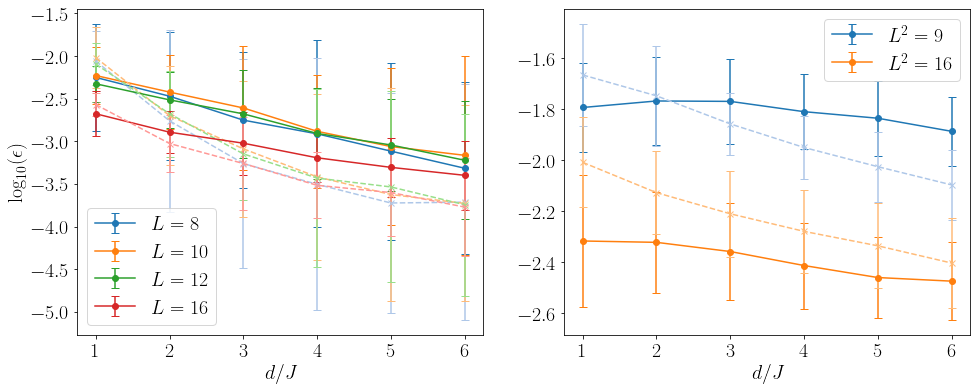

In [4]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
mpl.rcParams['figure.figsize'] = (16,6)

fig, axes = plt.subplots(1,2)
ax1,ax2 = axes
axlist = [ax1,ax2]

order = 4
x = 0.0
delta = 0.1
tlist = np.logspace(-2,5,151,base=10,endpoint=True)
reps = 1024
dlist = [1.0,2.0,3.0,4.0,5.0,6.0]

for n in [8,10,12,16]:
    nvar = utility.namevar2('random',1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('err_med'))]
            except:
                None

        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))

        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax1.errorbar(dlist,np.log10(corr),corr_var,fmt='o-',capsize=4,label=r'$L = %s$' %n)
    
    nvar = utility.namevar2('QPgolden',1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('err_med'))]
            except:
                None
            
        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))
        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax1.errorbar(dlist,np.log10(corr),corr_var,fmt='x--',capsize=4)
    
    
for n in [9,16]:
    nvar = utility.namevar2('random',2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('err_med'))]
            except:
                None

        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))

        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax2.errorbar(dlist,np.log10(corr),corr_var,fmt='o-',capsize=4,label=r'$L^2 = %s$' %n)
    
    nvar = utility.namevar2('QPgolden',2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('err_med'))]
            except:
                None
            
        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))
        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax2.errorbar(dlist,np.log10(corr),corr_var,fmt='x--',capsize=4)

ax1.legend()
ax2.legend(loc='upper right')
ax1.set(xlabel=(r'$d/J$'),ylabel=(r'$\log_{10}(\epsilon)$'))
ax2.set(xlabel=(r'$d/J$'))
plt.savefig('fig_ed_err.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

### Error: Truncation error based on tensor Frobenius norm

8 random 1.0 1024
8 random 2.0 1024
8 random 3.0 1024
8 random 4.0 1024
8 random 5.0 1024
8 QP 1.0 1024
8 QP 2.0 1024
8 QP 3.0 1024
8 QP 4.0 1024
8 QP 5.0 1024
10 random 1.0 512
10 random 2.0 512
10 random 3.0 512
10 random 4.0 512
10 random 5.0 512
10 QP 1.0 512
10 QP 2.0 512
10 QP 3.0 512
10 QP 4.0 512
10 QP 5.0 512
12 random 1.0 512
12 random 2.0 512
12 random 3.0 512
12 random 4.0 512
12 random 5.0 512
12 QP 1.0 512
12 QP 2.0 512
12 QP 3.0 512
12 QP 4.0 512
12 QP 5.0 512
16 random 1.0 256
16 random 2.0 255
16 random 3.0 256
16 random 4.0 256
16 random 5.0 256
16 QP 1.0 256
16 QP 2.0 256
16 QP 3.0 256
16 QP 4.0 256
16 QP 5.0 256
24 random 1.0 128
24 random 2.0 128
24 random 3.0 128
24 random 4.0 128
24 random 5.0 128
24 QP 1.0 128
24 QP 2.0 128
24 QP 3.0 128
24 QP 4.0 128
24 QP 5.0 128
36 random 1.0 128
36 random 2.0 128
36 random 3.0 128
36 random 4.0 128
36 random 5.0 128
36 QP 1.0 127
36 QP 2.0 128
36 QP 3.0 128
36 QP 4.0 128
36 QP 5.0 128
48 random 1.0 127
48 random 2.0 127
48 r

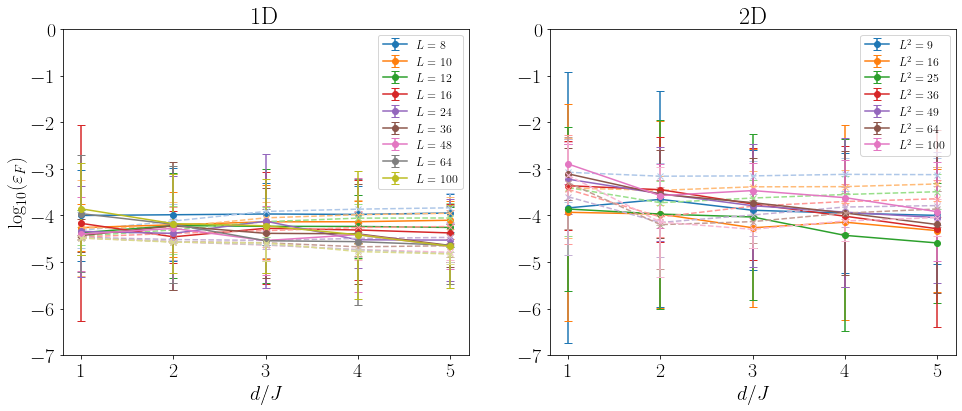

In [25]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
mpl.rcParams['figure.figsize'] = (16,6)

fig, axes = plt.subplots(1,2)
ax1,ax2 = axes
axlist = [ax1,ax2]

order = 4
x = 0.0
delta = 0.1
tlist = np.logspace(-2,5,151,base=10,endpoint=True)
reps = 1024
dlist = [1.0,2.0,3.0,4.0,5.0]

for n in [8,10,12,16,24,36,48,64,100]:
    nvar = utility.namevar2('random',1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('trunc_err'))[0]]
            except:
                None
        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))

        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax1.errorbar(dlist,np.log10(corr),corr_var,fmt='o-',capsize=4,label=r'$L = %s$' %n)
    
    nvar = utility.namevar2('QPgolden',1,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    if np.array(hf.get('trunc_err'))[0] > 0:
                    # Negative values mean that I didn't compute this error in the original simulations
                        errlist += [np.array(hf.get('trunc_err'))[0]]
            except:
                None  
        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))
        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax1.errorbar(dlist,np.log10(corr),corr_var,fmt='x--',capsize=4)
    
    
for n in [9,16,25,36,49,64,100]:
    nvar = utility.namevar2('random',2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('trunc_err'))[0]]
            except:
                None

        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))

        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax2.errorbar(dlist,np.log10(corr),corr_var,fmt='o-',capsize=4,label=r'$L^2 = %s$' %n)
    
    nvar = utility.namevar2('QPgolden',2,dsymm,'CDW',dyn,norm,n,LIOM,species,order)
    corr = np.zeros(len(dlist))
    corr_var = np.zeros(len(dlist))
    dc = 0
    for d in dlist:
        errlist = []
        for p in range(1,reps+1):
            try:
                with h5py.File('proc/%s/tflow-d%.2f-O4-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,p),'r') as hf:
                    errlist += [np.array(hf.get('trunc_err'))[0]]
            except:
                None
            
        corr[dc] = np.mean(np.abs(errlist),axis=0)
        corr_var0 = np.sqrt(np.var(np.abs(errlist),axis=0))
        corr_var[dc] = corr_var0/(corr[dc]*np.log(10))
        dc += 1

    ax2.errorbar(dlist,np.log10(corr),corr_var,fmt='x--',capsize=4)

ax1.legend(fontsize=12,loc='upper right')
ax2.legend(fontsize=12)
ax1.set(xlabel=(r'$d/J$'),ylabel=(r'$\log_{10}(\varepsilon_F)$'),title=r'1D',ylim=(-7,0))
ax2.set(xlabel=(r'$d/J$'),title=r'2D',ylim=(-7,0))
plt.savefig('fig_ed_trunc_err.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

### Induced disorder bandwidth & scrambling transform comparion

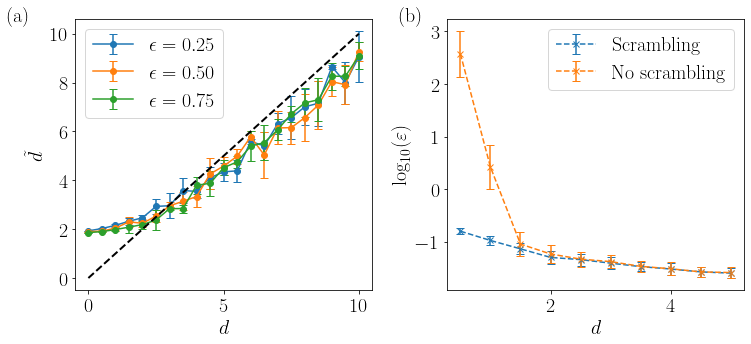

In [31]:
from scipy.integrate import ode

# Function to contract square matrices (matrix multiplication)
def comm(A,B):
    return np.einsum('ik,kj ->ij ',A,B) - np.einsum('ik,kj ->ij',B,A)

# Function to compute the RHS of the flow equation for a given generator eta (specified in advance)
def nonint_ode_random(l,H,n,cutoff=0.75):
    
    H = H.reshape(n,n)
    
    reslist = res(n,H,cutoff=cutoff)
    eta_random = np.zeros((n,n))
    for r in reslist:
        eta_random[r[0],r[1]] = np.sign(r[0]-r[1])*r[2]
        eta_random[r[1],r[0]] = -eta_random[r[0],r[1]]
    sol = comm(eta_random,H)

    return sol.reshape(n**2)

# Function to diagonalize Hamiltonian using the Wegner/adaptive generators
# Falls back on pure Wegner generator if random = False
def flow_nonint(H,dl_list,random=True,epsilon=0.0,cutoff=0.75):
    
    flow_time = []
    flow_sol = []
    count = 0
    
    if random == True:    
        
        reslist = res(n,H,cutoff=cutoff)
        while len(reslist)>0:
            # Apply random unitary
            dm_list = np.linspace(0,10,21,endpoint=True)
            sol=np.zeros((len(dm_list),n,n))
            sol[0] = H.reshape(n,n)

            # Define integrator
            r = ode(nonint_ode_random).set_integrator('dopri5',rtol=1e-3,atol=1e-3,nsteps=100)
            r.set_initial_value((H).reshape(n**2),dm_list[0])
            r.set_f_params(n,cutoff)

            k = 1
            test = 1
            while r.successful() and k < len(dm_list):
                r.integrate(dm_list[k])
                sol[k] = (r.y).reshape(n,n)
                k += 1
            H = (r.y).reshape(n,n)
            reslist = res(n,H,cutoff=cutoff)

            count += 1

    return np.diag(H)

mpl.rcParams['figure.figsize'] = (12,5)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
fig, axes = plt.subplots(1,2)
ax1,ax2 = axes

# Generate list of flow time steps to store
dl_list0 = np.linspace(0,15,100,endpoint = True)
random = True

n = 12
J = 1.0
reps = 5
# NOTE: To reproduce the figure in the paper, set n = 36 and reps = 50.
# Keep in mind that this is random and the quantitative results will change from run-to-run.

dlist = [0.5*i for i in range(21)]

# Function to identify single-particle resonances
def res(n,H2,cutoff=0.5):
    reslist = []
    for i in range(n):
        for j in range(i):
            if np.abs(H2[i,j])>cutoff*np.abs(H2[i,i]-H2[j,j]):
                reslist += [[i,j,H2[i,j]]]
    return reslist

for cutoff in [0.25,0.5,0.75]:
    bw_list = np.zeros((reps,len(dlist)))
    diff_list = np.zeros((reps,len(dlist)))
    for p in range(reps):
        dc = 0
        for d in dlist:
            H = np.zeros((n,n))
            H += np.diag([d*np.random.uniform(-1,1) for i in range(n)])
            H += J*np.diag(np.ones(n-1),1) + J*np.diag(np.ones(n-1),-1)
            eig,V = np.linalg.eig(H)

            diag = flow_nonint(H,[0.],epsilon=0.,cutoff=cutoff)
            bw = (np.max(diag)-np.min(diag))/2.
            diff = []
            for i in range(n):
                for j in range(n):
                    if i != j:
                        diff += [(diag[i]-diag[j])**2]
            bw_list[p,dc] = bw
            diff_list[p,dc] = np.mean(diff)
            dc += 1 
    
    bw_var = np.sqrt(np.var(bw_list,axis=0))
    bw_list = np.mean(bw_list,axis=0)
    diff_var = np.sqrt(np.var(diff_list,axis=0))
    diff_list = np.mean(diff_list,axis=0)
    ax1.errorbar(dlist,bw_list,bw_var,fmt='o-',capsize=4,label=r'$\epsilon = %.2f$' %cutoff)
    
ax1.plot(dlist,np.array(dlist),'k--',linewidth=2,zorder=10)

ax1.set(xlabel=r'$d$',ylabel=r'$\tilde{d}$')

ax1.legend(fontsize=20)
ax1.text(-3,10.5,r'(a)')
ax1.text(11.5,10.5,r'(b)')


n = 10
dis = [0.5*i for i in range(1,11)]
J = 0.5
delta = 1.0
reps = 192

for lmax in [50]:
    arg_err = np.zeros((len(dis),reps))
    arg_err_med = np.zeros((len(dis),reps))
    ag_err = np.zeros((len(dis),reps))
    ag_err_med = np.zeros((len(dis),reps))
    wg_err = np.zeros((len(dis),reps))
    wg_err_med = np.zeros((len(dis),reps))

    dc = 0
    for d in dis:
        for p in range(reps):
            with h5py.File('adaptive/dataN%s/adapt-lmax%s-d%.2f-J%.2f-Jz%.2f-p%s.h5' %(n,lmax,d,J,delta,p),'r') as hf:

                ag_err[dc,p] = np.array(hf.get('ag_err'))
                ag_err_med[dc,p] = np.array(hf.get('ag_err_med'))

                wg_err[dc,p] = np.array(hf.get('wg_err'))
                wg_err_med[dc,p] = np.array(hf.get('wg_err_med'))
        dc += 1

    if lmax == 10:
        ax = ax1
    elif lmax == 50:
        ax = ax2
    elif lmax == 500:
        ax = ax3

    ag_mean = np.mean(ag_err,axis=-1)
    ag_var = np.sqrt(np.var(ag_err,axis=-1)/reps)
    ag_var_log = [ag_var[i]/ag_mean[i]/np.log(10) for i in range(len(ag_var))]

    ag_med = np.median(ag_err_med,axis=-1)
    ag_mvar = np.median([np.abs(ag_err_med[::,i]-ag_med) for i in range(len(ag_err_med[0]))],axis=0)
    ag_mvar_log = [ag_mvar[i]/ag_med[i]/np.log(10) for i in range(len(ag_mvar))]

    wg_mean = np.mean(wg_err,axis=-1)
    wg_var = np.sqrt(np.var(wg_err,axis=-1)/reps)
    wg_var_log = [wg_var[i]/wg_mean[i]/np.log(10) for i in range(len(wg_var))]

    wg_med = np.median(wg_err_med,axis=-1)
    wg_mvar = np.median([np.abs(wg_err_med[::,i]-wg_med) for i in range(len(wg_err_med[0]))],axis=0)
    wg_mvar_log = [wg_mvar[i]/wg_med[i]/np.log(10) for i in range(len(wg_mvar))]

    ax.errorbar(dis,np.log10(ag_med),ag_mvar_log,fmt='x--',capsize=4,label=r'Scrambling')
    ax.errorbar(dis,np.log10(wg_med),wg_mvar_log,fmt='x--',capsize=4,label=r'No scrambling ')
        

ax2.set(xlabel=r'$d$',ylabel=r'$\log_{10}(\varepsilon)$')
ax2.legend()
fig.align_ylabels()
fig.align_xlabels()
plt.subplots_adjust(hspace=0.35,wspace=0.25)
plt.savefig('scrambling_details.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()